In [57]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM2 import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.4
G = 0.15
Ndd = 15
lamdai = [4.6,12,22]

### load epoch & cal epoch , define "x"

In [58]:
name = '2010DG77'
#df = pd.read_table(f'ws.dat.{name}')
ast = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(5,6,7))
ear = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(8,9,10))
#ast-sun
d_N = np.sqrt(ast[:,0]**2+ast[:,1]**2+ast[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((ast[:,0]-ear[:,0])**2+(ast[:,1]-ear[:,1])**2+(ast[:,2]-ear[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(ear[:,0]**2+ear[:,1]**2+ear[:,2]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
x = (delta_N,d_N,alpha_N)

### load obs data , define "y"

In [59]:
time = np.loadtxt(f'mba.jd.{name}')
mjdtime = time-2400000.5
obsdat = np.loadtxt(f'obsNEW.txt.{name}')
n4 = len(obsdat)//4
w1 = obsdat[:n4]
w2 = obsdat[n4:2*n4]
w3 = obsdat[2*n4:n4*3]
w4 = obsdat[n4*3:]
'''plt.subplot(2,1,1)
plt.plot(mjdtime[:n3//2+5],w2[:n3//2+5],'bo',label='w2')
plt.plot(mjdtime[:n3//2+5],w3[:n3//2+5],'yo',label='w3')
plt.plot(mjdtime[:n3//2+5],w4[:n3//2+5],'ro',label='w4')
plt.subplot(2,1,2)
plt.plot(mjdtime[n3//2+5:],w2[n3//2+5:],'bo',label='w2')
plt.plot(mjdtime[n3//2+5:],w3[n3//2+5:],'yo',label='w3')
plt.plot(mjdtime[n3//2+5:],w4[n3//2+5:],'ro',label='w4')
plt.legend()'''
y = obsdat

## model

In [60]:
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf  = theta
    astp,obsp = x
    lamda2,lamda3,lamda4 = lamda
    #print('k',astp)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    flux = np.zeros(n4*4)
    for i in range(n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,3.4,eta,A,Hv)
        flux[i] = 1.3917*fluxi + 1.0049*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4,2*n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = 1.1124*fluxi + 1.0193*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(2*n4,n4*3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A,Hv)
        flux[i] = 0.8791*fluxi 
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4*3,n4*4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A,Hv)
        flux[i] = 0.9865*fluxi     
       # print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    return flux    

### cal flux with ref

/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


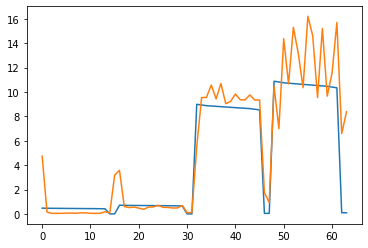

In [61]:
xast = np.vstack((ast,ast,ast,ast))
xear  =  np.vstack((ear,ear,ear,ear))
xt = (xast,xear)
flux = Model_neatm_Ref_jhx((1.5,115,0.5),xt,(4.6,12,22))
plt.plot(flux)
plt.plot(y)

## MCMC

In [62]:
#initial
eta_gs = 1.5
D_gs = 115
eta_gss = [0.1,3,0.05]
D_gss = [50,300,2]
wf_gs = 0.5
wf_gss = [0.01,1,0.1]
logf_gs = 0.4
logf_gss = [-10,1]

In [63]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
logf = logf_gs
test = [eta, D,wf]

In [73]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx([eta_gss[0],D_gss[0],wf_gss[0]],xt,lamdai),1))


LossFunction =  21.897790712938658


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


In [76]:
n_eta = int((eta_gss[1]-eta_gss[0])/eta_gss[2]+1)                     
n_D = int((D_gss[1]-D_gss[0])/D_gss[2]+1)
n_wf = int((wf_gss[1]-wf_gss[0])/wf_gss[2]+1)
Ntime = n_eta*n_D*n_wf         
print(f'It`s need {Ntime} setps',f'eta={n_eta} d={n_D}')

minloss = 10e6
nstep = 0
Di = D_gss[0]
for i in tqdm(range(n_D)):
    etai = eta_gss[0]
    for j in tqdm(range(n_eta), leave=False):
        wfi = wf_gss[0]
        for k in range(n_wf):
            flux = np.zeros(n4*4)
            testi = [etai,Di,wfi]
            flux = Model_neatm_Ref_jhx(testi,xt,lamdai)
            lossi = loss(y,flux,1)
            if lossi<minloss :
                minloss = lossi
                eta_fit = etai
                D_fit  = Di
                wf_fit  = wfi
                print(f'step {nstep} :loss = {lossi} eta = {eta_fit} D = {D_fit} wf = {wf_fit}')
            wfi = wfi + wf_gss[2]
            nstep = nstep + 1
        etai = etai + eta_gss[2]
    Di = Di + D_gss[2]


It`s need 73080 setps eta=58 d=126


  0%|          | 0/126 [00:00<?, ?it/s]

step 0 :loss = 21.897790712938658 eta = 0.1 D = 50 wf = 0.01


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
  1%|          | 1/126 [00:49<1:43:37, 49.74s/it]

step 580 :loss = 17.619415823132506 eta = 0.1 D = 52 wf = 0.01


  2%|▏         | 2/126 [01:40<1:43:40, 50.16s/it]


step 1160 :loss = 15.237535961503776 eta = 0.1 D = 54 wf = 0.01


  2%|▏         | 3/126 [02:29<1:41:42, 49.61s/it]


step 1740 :loss = 14.745446844840384 eta = 0.1 D = 56 wf = 0.01


  3%|▎         | 4/126 [03:25<1:46:27, 52.35s/it]

step 2330 :loss = 13.603337179834387 eta = 0.15000000000000002 D = 58 wf = 0.01


  4%|▍         | 5/126 [04:36<1:58:49, 58.92s/it]

step 2910 :loss = 12.65369284052954 eta = 0.15000000000000002 D = 60 wf = 0.01


  5%|▍         | 6/126 [05:46<2:05:45, 62.88s/it]

step 3500 :loss = 12.108402291281033 eta = 0.2 D = 62 wf = 0.01


  6%|▌         | 7/126 [07:03<2:13:34, 67.35s/it]

step 4080 :loss = 11.213215029870108 eta = 0.2 D = 64 wf = 0.01


  6%|▋         | 8/126 [08:19<2:18:14, 70.29s/it]

step 4660 :loss = 11.090618918201566 eta = 0.2 D = 66 wf = 0.01


step 4670 :loss = 10.766869615836029 eta = 0.25 D = 66 wf = 0.01


  7%|▋         | 9/126 [09:37<2:21:34, 72.60s/it]

step 5250 :loss = 10.046903589510912 eta = 0.25 D = 68 wf = 0.01


  8%|▊         | 10/126 [10:47<2:18:33, 71.67s/it]

step 5830 :loss = 9.939691682966822 eta = 0.25 D = 70 wf = 0.01
step 5840 :loss = 9.606050048135417 eta = 0.3 D = 70 wf = 0.01


  9%|▊         | 11/126 [11:57<2:16:15, 71.10s/it]

step 6420 :loss = 9.098366712128872 eta = 0.3 D = 72 wf = 0.01


 10%|▉         | 12/126 [13:04<2:12:56, 69.97s/it]

step 7010 :loss = 8.644676199478555 eta = 0.35 D = 74 wf = 0.01


 10%|█         | 13/126 [14:11<2:10:23, 69.23s/it]

step 7590 :loss = 8.36231467505838 eta = 0.35 D = 76 wf = 0.01


step 7600 :loss = 8.348259537448527 eta = 0.39999999999999997 D = 76 wf = 0.01


 11%|█         | 14/126 [15:21<2:09:30, 69.38s/it]

step 8180 :loss = 7.895423522237669 eta = 0.39999999999999997 D = 78 wf = 0.01


 12%|█▏        | 15/126 [16:34<2:10:24, 70.49s/it]


step 8760 :loss = 7.843381651160809 eta = 0.39999999999999997 D = 80 wf = 0.01



 16%|█▌        | 9/58 [00:11<00:59,  1.21s/it]

step 8770 :loss = 7.564992054731433 eta = 0.44999999999999996 D = 80 wf = 0.01


 13%|█▎        | 16/126 [17:47<2:10:13, 71.03s/it]

step 9350 :loss = 7.367375522826516 eta = 0.44999999999999996 D = 82 wf = 0.01


step 9360 :loss = 7.302599649646327 eta = 0.49999999999999994 D = 82 wf = 0.01


 13%|█▎        | 17/126 [19:00<2:10:27, 71.81s/it]

step 9940 :loss = 7.015568439605809 eta = 0.49999999999999994 D = 84 wf = 0.01


 14%|█▍        | 18/126 [20:14<2:10:13, 72.34s/it]


step 10530 :loss = 6.735103155677981 eta = 0.5499999999999999 D = 86 wf = 0.01


 15%|█▌        | 19/126 [21:27<2:09:18, 72.51s/it]

step 11110 :loss = 6.703591927543604 eta = 0.5499999999999999 D = 88 wf = 0.01


step 11120 :loss = 6.4977011446151245 eta = 0.6 D = 88 wf = 0.01


 16%|█▌        | 20/126 [22:36<2:06:30, 71.61s/it]

step 11700 :loss = 6.413597668024331 eta = 0.6 D = 90 wf = 0.01


step 11710 :loss = 6.287875198799902 eta = 0.65 D = 90 wf = 0.01


 17%|█▋        | 21/126 [23:50<2:06:36, 72.35s/it]

step 12290 :loss = 6.172902027748009 eta = 0.65 D = 92 wf = 0.01


step 12300 :loss = 6.097088597902092 eta = 0.7000000000000001 D = 92 wf = 0.01


 17%|█▋        | 22/126 [24:58<2:03:14, 71.10s/it]

step 12880 :loss = 5.966965025302118 eta = 0.7000000000000001 D = 94 wf = 0.01


step 12890 :loss = 5.920705541465255 eta = 0.7500000000000001 D = 94 wf = 0.01


 18%|█▊        | 23/126 [26:10<2:02:11, 71.18s/it]

step 13470 :loss = 5.78705926094371 eta = 0.7500000000000001 D = 96 wf = 0.01
step 13480 :loss = 5.756330587122428 eta = 0.8000000000000002 D = 96 wf = 0.01


 19%|█▉        | 24/126 [27:24<2:02:38, 72.15s/it]

step 14060 :loss = 5.627925832111357 eta = 0.8000000000000002 D = 98 wf = 0.01


step 14070 :loss = 5.602873285510978 eta = 0.8500000000000002 D = 98 wf = 0.01


 20%|█▉        | 25/126 [28:36<2:01:29, 72.18s/it]

step 14650 :loss = 5.486424367396642 eta = 0.8500000000000002 D = 100 wf = 0.01


step 14660 :loss = 5.460006842311502 eta = 0.9000000000000002 D = 100 wf = 0.01


 21%|██        | 26/126 [29:46<1:58:58, 71.38s/it]


step 15240 :loss = 5.360731434886263 eta = 0.9000000000000002 D = 102 wf = 0.01
step 15250 :loss = 5.327848127210771 eta = 0.9500000000000003 D = 102 wf = 0.01


 21%|██▏       | 27/126 [30:53<1:55:45, 70.15s/it]

step 15830 :loss = 5.249852272420332 eta = 0.9500000000000003 D = 104 wf = 0.01


step 15840 :loss = 5.206765545140787 eta = 1.0000000000000002 D = 104 wf = 0.01


 22%|██▏       | 28/126 [31:56<1:50:53, 67.90s/it]

step 16420 :loss = 5.153317000853895 eta = 1.0000000000000002 D = 106 wf = 0.01
step 16430 :loss = 5.097262506967688 eta = 1.0500000000000003 D = 106 wf = 0.01


 23%|██▎       | 29/126 [32:58<1:47:03, 66.23s/it]


step 17010 :loss = 5.07098830066511 eta = 1.0500000000000003 D = 108 wf = 0.01
step 17020 :loss = 4.999906463850328 eta = 1.1000000000000003 D = 108 wf = 0.01


 24%|██▍       | 30/126 [34:01<1:44:26, 65.28s/it]

step 17610 :loss = 4.915285828370555 eta = 1.1500000000000004 D = 110 wf = 0.01


 25%|██▍       | 31/126 [35:04<1:42:14, 64.57s/it]

step 18200 :loss = 4.843984164609795 eta = 1.2000000000000004 D = 112 wf = 0.01


 25%|██▌       | 32/126 [36:07<1:40:20, 64.05s/it]


step 18790 :loss = 4.786565157501668 eta = 1.2500000000000004 D = 114 wf = 0.01
step 18800 :loss = 4.77123549381178 eta = 1.3000000000000005 D = 114 wf = 0.01


 26%|██▌       | 33/126 [37:11<1:39:06, 63.95s/it]

step 19380 :loss = 4.74356433646018 eta = 1.3000000000000005 D = 116 wf = 0.01


step 19390 :loss = 4.704601845446381 eta = 1.3500000000000005 D = 116 wf = 0.01


 27%|██▋       | 34/126 [38:15<1:38:20, 64.14s/it]

step 19980 :loss = 4.652926980490592 eta = 1.4000000000000006 D = 118 wf = 0.01


 28%|██▊       | 35/126 [39:18<1:36:31, 63.65s/it]


step 20570 :loss = 4.616720500922959 eta = 1.4500000000000006 D = 120 wf = 0.01
step 20571 :loss = 4.6166705804265895 eta = 1.4500000000000006 D = 120 wf = 0.11
step 20580 :loss = 4.61250800498822 eta = 1.5000000000000007 D = 120 wf = 0.01
step 20581 :loss = 4.612325406395169 eta = 1.5000000000000007 D = 120 wf = 0.11
step 20582 :loss = 4.612198356721551 eta = 1.5000000000000007 D = 120 wf = 0.21000000000000002
step 20583 :loss = 4.612126855967364 eta = 1.5000000000000007 D = 120 wf = 0.31000000000000005
step 20584 :loss = 4.612110904132608 eta = 1.5000000000000007 D = 120 wf = 0.41000000000000003


 29%|██▊       | 36/126 [40:18<1:33:50, 62.56s/it]

step 21160 :loss = 4.596445946739975 eta = 1.5000000000000007 D = 122 wf = 0.01
step 21161 :loss = 4.596332833805513 eta = 1.5000000000000007 D = 122 wf = 0.11
step 21162 :loss = 4.59627526979048 eta = 1.5000000000000007 D = 122 wf = 0.21000000000000002
step 21163 :loss = 4.59627325469488 eta = 1.5000000000000007 D = 122 wf = 0.31000000000000005


step 21170 :loss = 4.566814676849978 eta = 1.5500000000000007 D = 122 wf = 0.01
step 21171 :loss = 4.566577372237594 eta = 1.5500000000000007 D = 122 wf = 0.11
step 21172 :loss = 4.566395616544643 eta = 1.5500000000000007 D = 122 wf = 0.21000000000000002
step 21173 :loss = 4.566269409771123 eta = 1.5500000000000007 D = 122 wf = 0.31000000000000005


 53%|█████▎    | 31/58 [00:31<00:27,  1.01s/it]


step 21174 :loss = 4.566198751917034 eta = 1.5500000000000007 D = 122 wf = 0.41000000000000003
step 21175 :loss = 4.566183642982377 eta = 1.5500000000000007 D = 122 wf = 0.51


 29%|██▉       | 37/126 [41:16<1:30:56, 61.31s/it]

step 21760 :loss = 4.537805613692338 eta = 1.6000000000000008 D = 124 wf = 0.01
step 21761 :loss = 4.537517065689967 eta = 1.6000000000000008 D = 124 wf = 0.11
step 21762 :loss = 4.537284066607025 eta = 1.6000000000000008 D = 124 wf = 0.21000000000000002
step 21763 :loss = 4.537106616443517 eta = 1.6000000000000008 D = 124 wf = 0.31000000000000005


step 21764 :loss = 4.53698471519944 eta = 1.6000000000000008 D = 124 wf = 0.41000000000000003
step 21765 :loss = 4.536918362874793 eta = 1.6000000000000008 D = 124 wf = 0.51
step 21766 :loss = 4.536907559469578 eta = 1.6000000000000008 D = 124 wf = 0.61


 30%|███       | 38/126 [42:14<1:28:20, 60.24s/it]

step 22350 :loss = 4.525847898020647 eta = 1.6500000000000008 D = 126 wf = 0.01
step 22351 :loss = 4.525511246670558 eta = 1.6500000000000008 D = 126 wf = 0.11
step 22352 :loss = 4.5252301442399006 eta = 1.6500000000000008 D = 126 wf = 0.21000000000000002
step 22353 :loss = 4.525004590728675 eta = 1.6500000000000008 D = 126 wf = 0.31000000000000005
step 22354 :loss = 4.52483458613688 eta = 1.6500000000000008 D = 126 wf = 0.41000000000000003
step 22355 :loss = 4.524720130464517 eta = 1.6500000000000008 D = 126 wf = 0.51
step 22356 :loss = 4.524661223711585 eta = 1.6500000000000008 D = 126 wf = 0.61


step 22357 :loss = 4.524657865878085 eta = 1.6500000000000008 D = 126 wf = 0.71
step 22360 :loss = 4.5121498898013215 eta = 1.7000000000000008 D = 126 wf = 0.01
step 22361 :loss = 4.51171437717861 eta = 1.7000000000000008 D = 126 wf = 0.11
step 22362 :loss = 4.511334413475329 eta = 1.7000000000000008 D = 126 wf = 0.21000000000000002
step 22363 :loss = 4.51100999869148 eta = 1.7000000000000008 D = 126 wf = 0.31000000000000005
step 22364 :loss = 4.5107411328270635 eta = 1.7000000000000008 D = 126 wf = 0.41000000000000003
step 22365 :loss = 4.510527815882076 eta = 1.7000000000000008 D = 126 wf = 0.51
step 22366 :loss = 4.510370047856522 eta = 1.7000000000000008 D = 126 wf = 0.61
step 22367 :loss = 4.510267828750399 eta = 1.7000000000000008 D = 126 wf = 0.71


step 22368 :loss = 4.5102211585637075 eta = 1.7000000000000008 D = 126 wf = 0.8099999999999999


 31%|███       | 39/126 [43:12<1:26:26, 59.62s/it]

step 22950 :loss = 4.492193169061258 eta = 1.7500000000000009 D = 128 wf = 0.01
step 22951 :loss = 4.491717959117233 eta = 1.7500000000000009 D = 128 wf = 0.11
step 22952 :loss = 4.491298298092641 eta = 1.7500000000000009 D = 128 wf = 0.21000000000000002
step 22953 :loss = 4.490934185987479 eta = 1.7500000000000009 D = 128 wf = 0.31000000000000005
step 22954 :loss = 4.4906256228017485 eta = 1.7500000000000009 D = 128 wf = 0.41000000000000003
step 22955 :loss = 4.490372608535449 eta = 1.7500000000000009 D = 128 wf = 0.51


step 22956 :loss = 4.490175143188582 eta = 1.7500000000000009 D = 128 wf = 0.61
step 22957 :loss = 4.490033226761145 eta = 1.7500000000000009 D = 128 wf = 0.71
step 22958 :loss = 4.489946859253141 eta = 1.7500000000000009 D = 128 wf = 0.8099999999999999
step 22959 :loss = 4.489916040664569 eta = 1.7500000000000009 D = 128 wf = 0.9099999999999999


 32%|███▏      | 40/126 [44:11<1:24:55, 59.24s/it]

step 23541 :loss = 4.489772412986369 eta = 1.800000000000001 D = 130 wf = 0.11
step 23542 :loss = 4.489315215478561 eta = 1.800000000000001 D = 130 wf = 0.21000000000000002
step 23543 :loss = 4.488913566890183 eta = 1.800000000000001 D = 130 wf = 0.31000000000000005
step 23544 :loss = 4.488567467221237 eta = 1.800000000000001 D = 130 wf = 0.41000000000000003
step 23545 :loss = 4.4882769164717224 eta = 1.800000000000001 D = 130 wf = 0.51


step 23546 :loss = 4.48804191464164 eta = 1.800000000000001 D = 130 wf = 0.61
step 23547 :loss = 4.4878624617309875 eta = 1.800000000000001 D = 130 wf = 0.71
step 23548 :loss = 4.4877385577397675 eta = 1.800000000000001 D = 130 wf = 0.8099999999999999
step 23549 :loss = 4.487670202667979 eta = 1.800000000000001 D = 130 wf = 0.9099999999999999
step 23550 :loss = 4.481975356073624 eta = 1.850000000000001 D = 130 wf = 0.01


step 23551 :loss = 4.481382357202234 eta = 1.850000000000001 D = 130 wf = 0.11
step 23552 :loss = 4.480844907250276 eta = 1.850000000000001 D = 130 wf = 0.21000000000000002
step 23553 :loss = 4.480363006217749 eta = 1.850000000000001 D = 130 wf = 0.31000000000000005
step 23554 :loss = 4.4799366541046535 eta = 1.850000000000001 D = 130 wf = 0.41000000000000003
step 23555 :loss = 4.479565850910989 eta = 1.850000000000001 D = 130 wf = 0.51
step 23556 :loss = 4.4792505966367555 eta = 1.850000000000001 D = 130 wf = 0.61
step 23557 :loss = 4.4789908912819545 eta = 1.850000000000001 D = 130 wf = 0.71
step 23558 :loss = 4.478786734846585 eta = 1.850000000000001 D = 130 wf = 0.8099999999999999
step 23559 :loss = 4.4786381273306475 eta = 1.850000000000001 D = 130 wf = 0.9099999999999999


 33%|███▎      | 41/126 [45:09<1:23:36, 59.01s/it]

step 24140 :loss = 4.4732929636359575 eta = 1.900000000000001 D = 132 wf = 0.01
step 24141 :loss = 4.472668525378435 eta = 1.900000000000001 D = 132 wf = 0.11
step 24142 :loss = 4.472099636040344 eta = 1.900000000000001 D = 132 wf = 0.21000000000000002
step 24143 :loss = 4.471586295621683 eta = 1.900000000000001 D = 132 wf = 0.31000000000000005
step 24144 :loss = 4.471128504122454 eta = 1.900000000000001 D = 132 wf = 0.41000000000000003


step 24145 :loss = 4.470726261542657 eta = 1.900000000000001 D = 132 wf = 0.51
step 24146 :loss = 4.470379567882292 eta = 1.900000000000001 D = 132 wf = 0.61
step 24147 :loss = 4.470088423141357 eta = 1.900000000000001 D = 132 wf = 0.71
step 24148 :loss = 4.469852827319854 eta = 1.900000000000001 D = 132 wf = 0.8099999999999999
step 24149 :loss = 4.469672780417783 eta = 1.900000000000001 D = 132 wf = 0.9099999999999999


 33%|███▎      | 42/126 [46:07<1:22:07, 58.67s/it]


step 24748 :loss = 4.4695969299682226 eta = 2.000000000000001 D = 134 wf = 0.8099999999999999
step 24749 :loss = 4.46932075135076 eta = 2.000000000000001 D = 134 wf = 0.9099999999999999


100%|██████████| 126/126 [2:01:13<00:00, 57.73s/it] 


[2.000000000000001, 134, 0.9099999999999999]


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


4.46932075135076

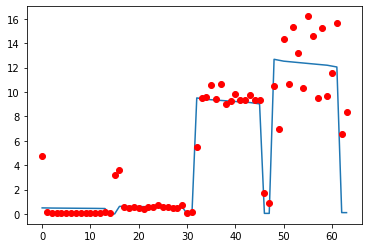

In [82]:
fitans = [eta_fit,D_fit,wf_fit]
print(fitans)
flux = Model_neatm_Ref_jhx(fitans,xt,(4.6,12,22))
plt.plot(flux)
plt.plot(y,'ro')
loss(y,flux,1)

5246.0
16 16


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


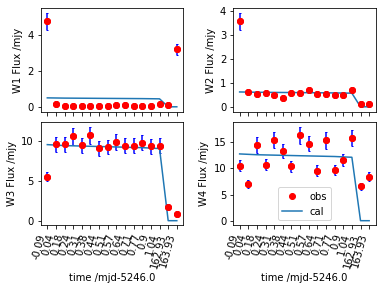

In [79]:
tjd = np.loadtxt(f'mba.jd.{name}')
tmjd = tjd-2450000.5
roundmjd = np.around(tmjd,0)
rmjd = min(roundmjd)
print(rmjd)
xtime = np.around(tmjd-rmjd,2)
yflux = Model_neatm_Ref_jhx(fitans,xt,lamdai)
plt.subplot(2,2,1)
plt.plot(y[:n4],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[:n4], yerr=y[:n4]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[:n4],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W1 Flux /mjy')
ax1 = plt.gca()
ax1.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,2)
plt.plot(y[n4:n4*2],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4:n4*2], yerr=y[n4:n4*2]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4:n4*2],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W2 Flux /mjy')
ax2 = plt.gca()
ax2.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,3)
plt.plot(y[n4*2:n4*3],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*2:n4*3], yerr=y[n4*2:n4*3]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*2:n4*3],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W3 Flux /mjy')

plt.subplot(2,2,4)
plt.plot(y[n4*3:],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*3:], yerr=y[n4*3:]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*3:],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W4 Flux /mjy')
plt.legend()
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.1)
print(len(tjd),n4)